# Table Recognition

这里进行表格的识别总体分为两个部分，一个是检测表格的顶点，分割出cell；另一个就是通过OCR来识别cell中的字符。

### 表格的检测

In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

path = 'E:/dataset/'
name='rectifyTable.jpg'
sourceTable = cv.imread(path+name)

要识别的原图：

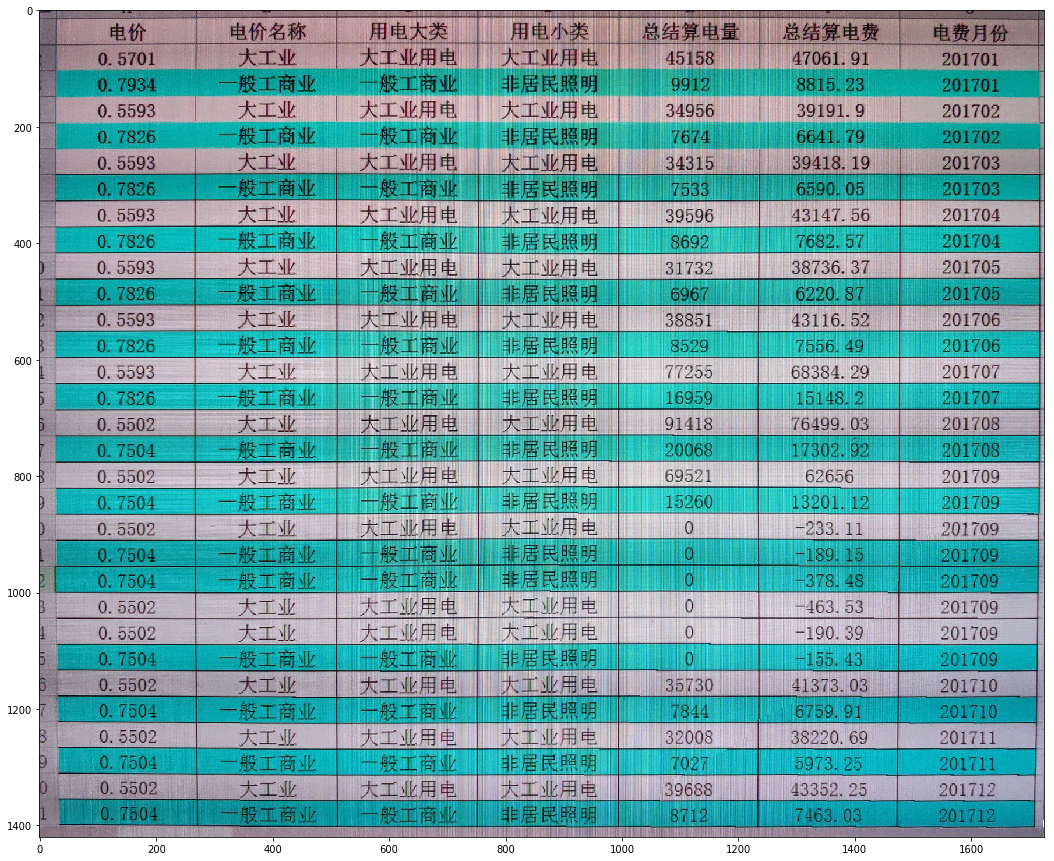

In [3]:
def printImg(img, colorMap=None):
    plt.figure(figsize=(18,18))
    plt.imshow(img, cmap=colorMap)
    plt.show()
    
printImg(sourceTable)

先转为灰度图

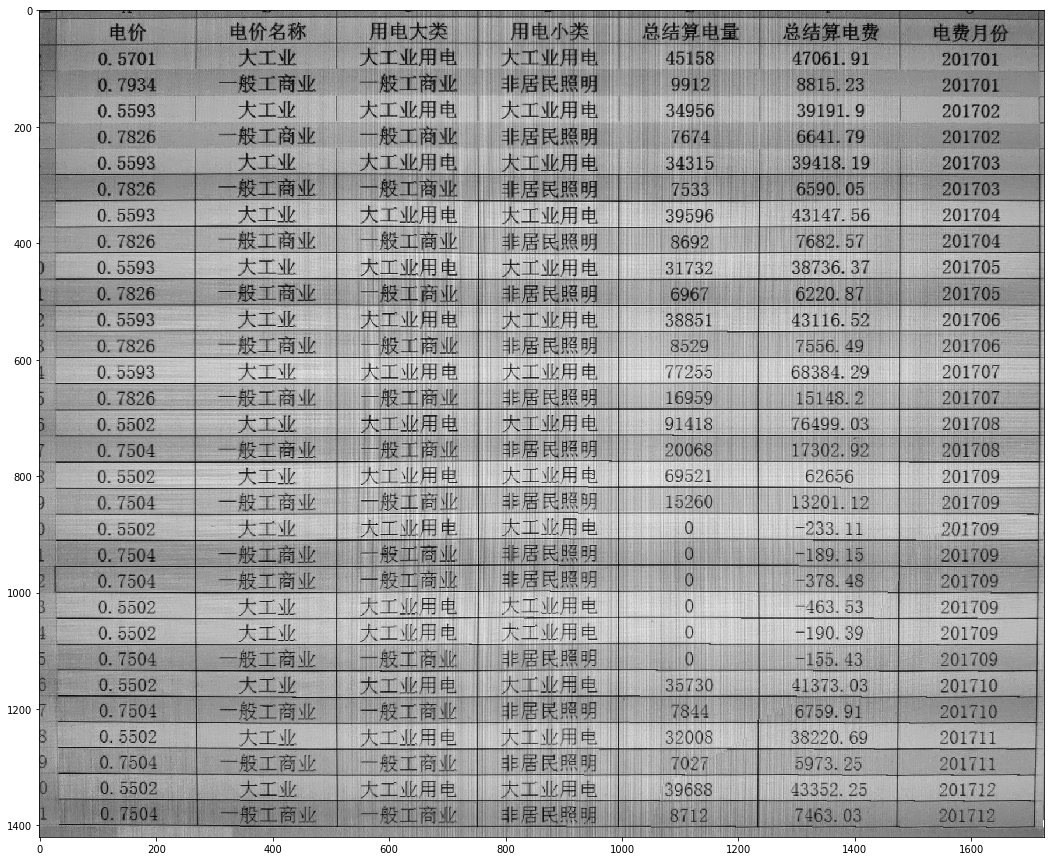

In [4]:
grayTable = cv.cvtColor(sourceTable, cv.COLOR_BGR2GRAY)
printImg(grayTable,'gray')

用adaptiveThreshold直接二值化

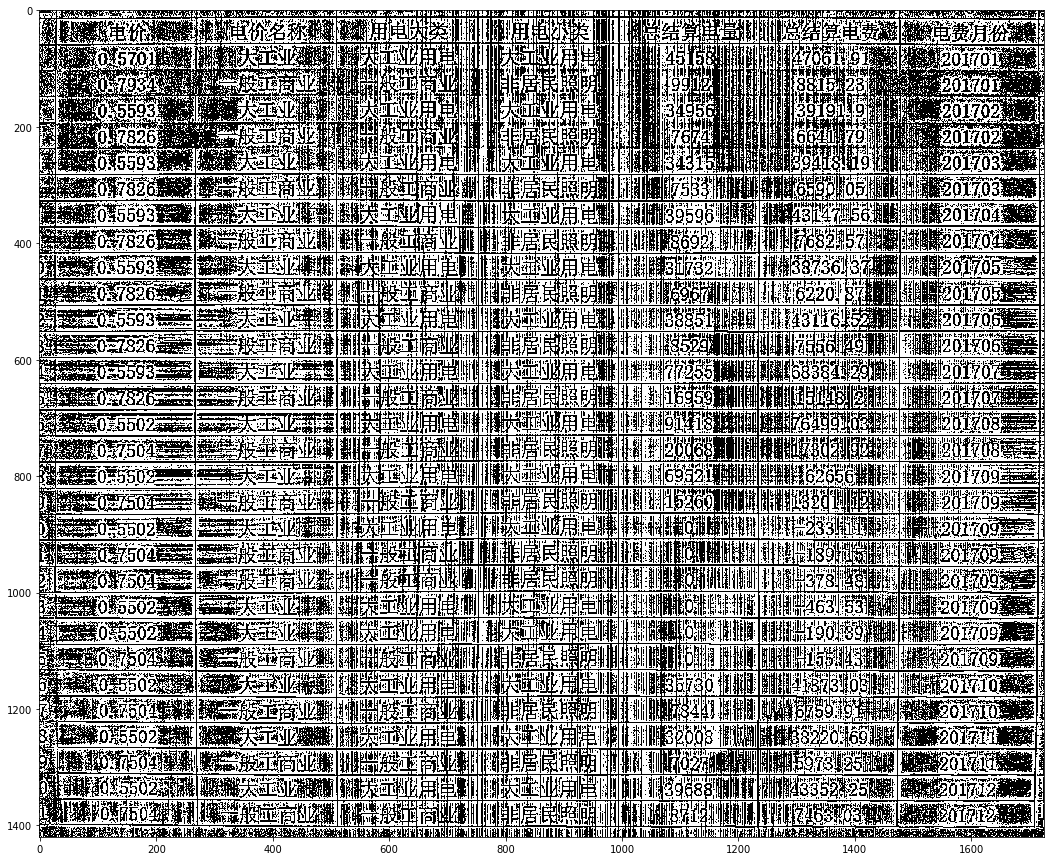

In [5]:
thresTable = cv.adaptiveThreshold(grayTable, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 15, -2)
printImg(thresTable,'gray')

先用中值滤波去除摩尔纹，再进行二值化

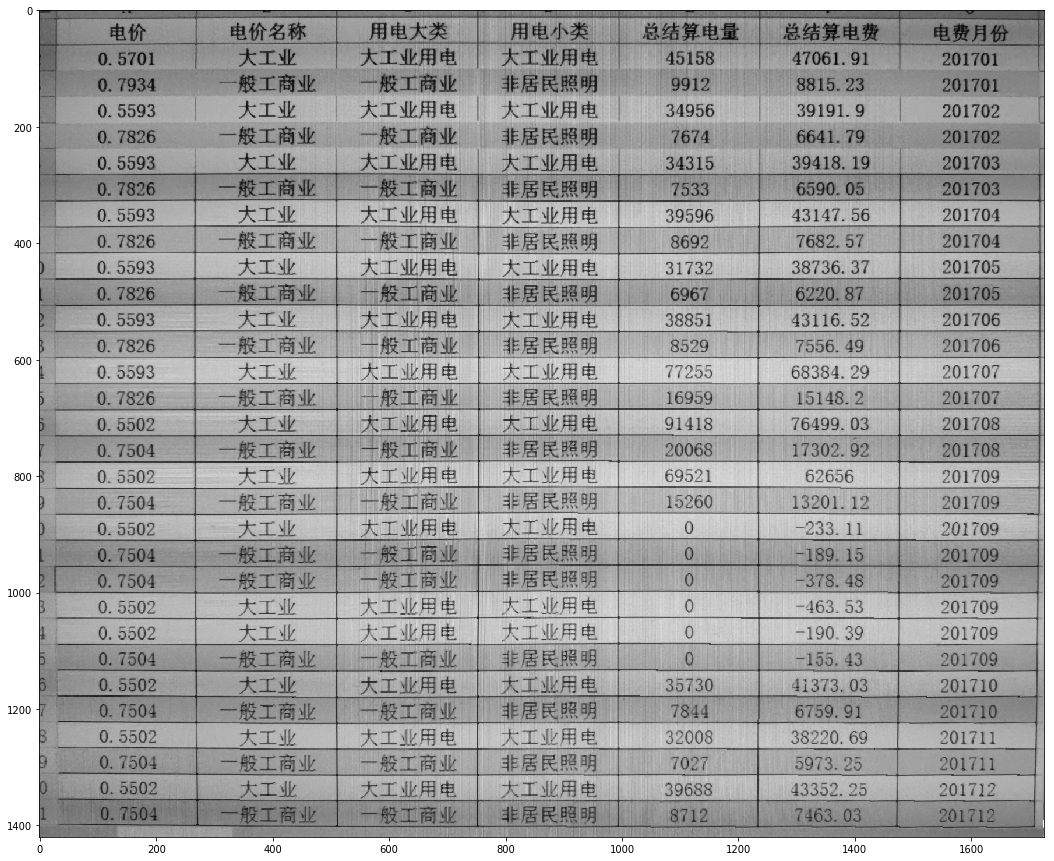

In [6]:
imgMedian = cv.medianBlur(grayTable, 3)
printImg(imgMedian, 'gray')

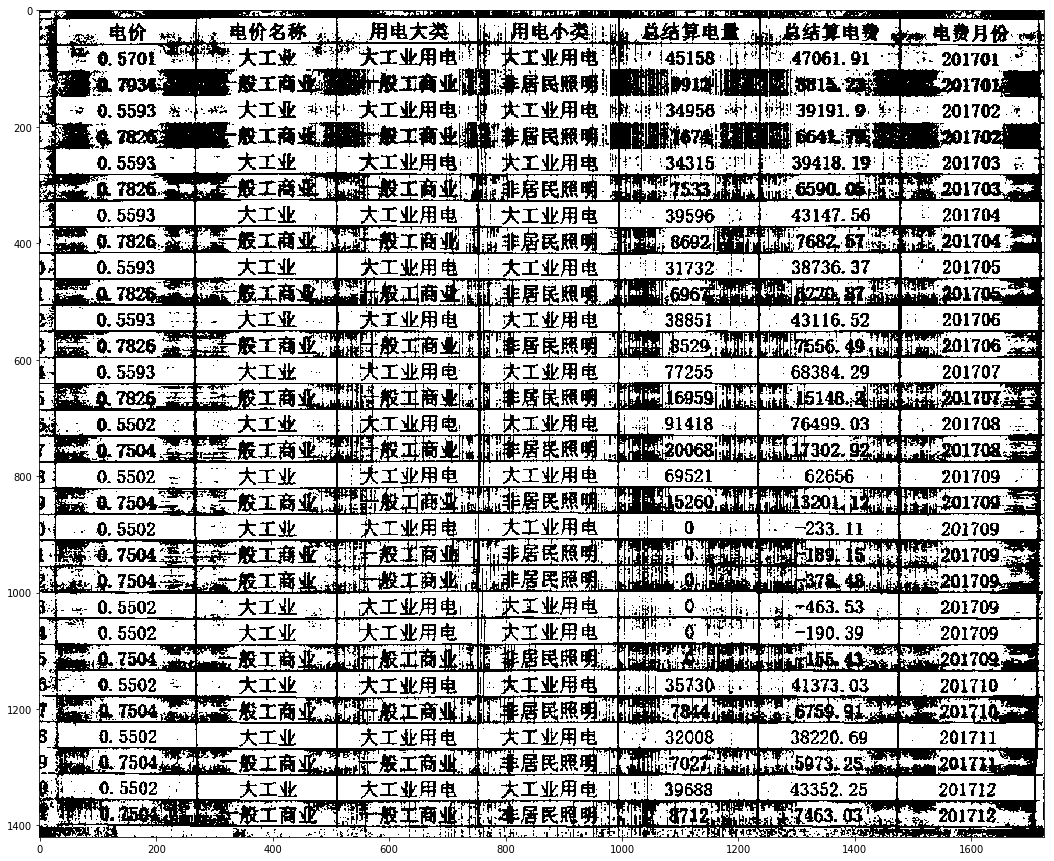

In [7]:
thresMedianImg = cv.adaptiveThreshold(imgMedian, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 53, -2)
printImg(thresMedianImg, 'gray')

可以看到，去除摩尔纹之后，二值化效果好了许多

定义膨胀腐蚀函数，先膨胀再腐蚀，生成的直线是白底黑线的

In [8]:
def dilaAndErode(img, kernel):
    img = cv.dilate(img, kernel)
    img = cv.erode(img, kernel)
    return img

scale关于要检测的线段的大小，scale越大，检测到的线段越多；

In [9]:
scaleHor = 20
scaleVec = 10
horizontalSize = thresMedianImg.shape[1] // scaleHor
verticalSize = thresMedianImg.shape[0] // scaleVec
horKernel = cv.getStructuringElement(cv.MORPH_RECT, (horizontalSize,1))
vecKernel = cv.getStructuringElement(cv.MORPH_RECT, (1, verticalSize))

horImg = dilaAndErode(thresMedianImg, horKernel)
vecImg = dilaAndErode(thresMedianImg, vecKernel)

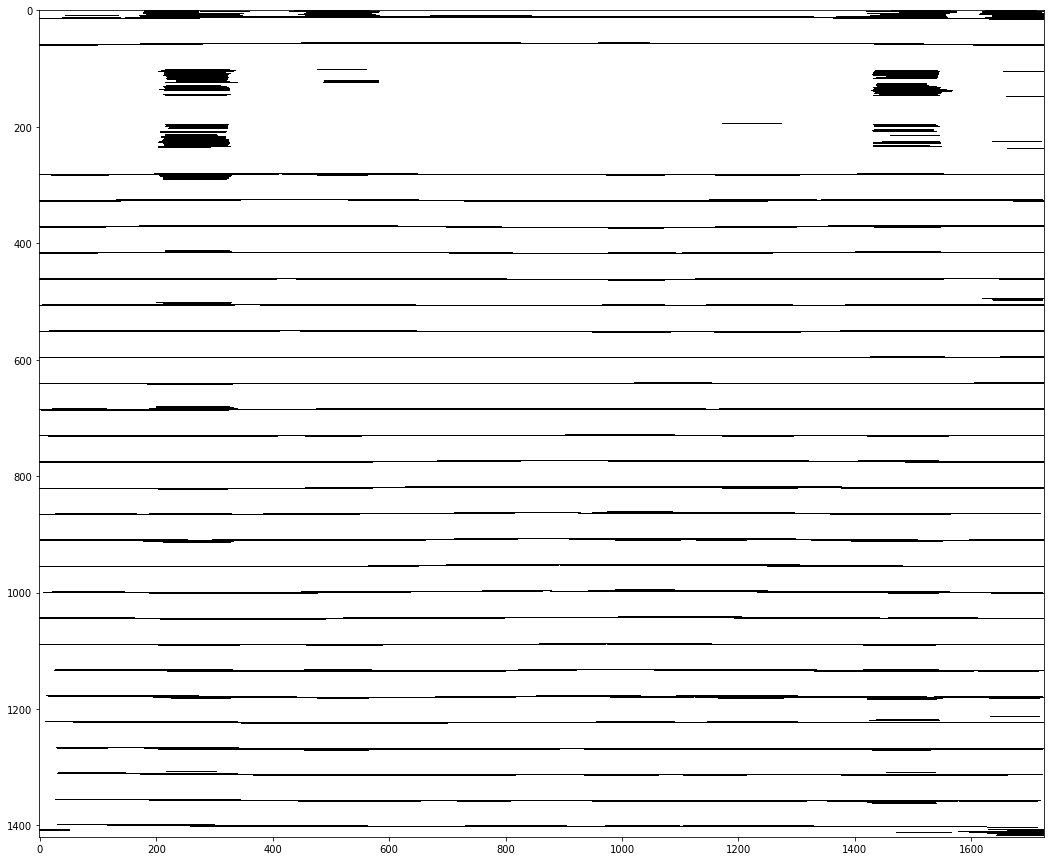

In [10]:
printImg(horImg, 'gray')

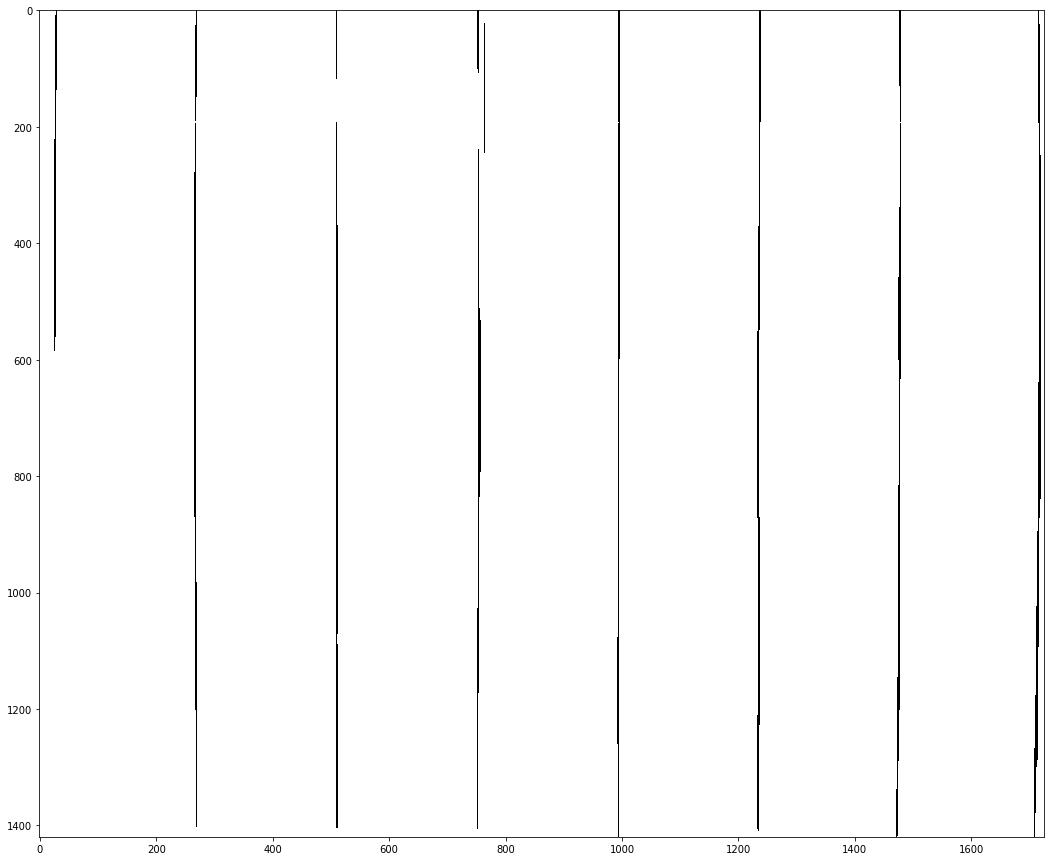

In [11]:
printImg(vecImg, 'gray')

为了方便后面处理，这里取了反色，然后求交点

In [12]:
horImg = cv.bitwise_not(horImg)
vecImg = cv.bitwise_not(vecImg)
dotImg = cv.bitwise_and(horImg, vecImg)

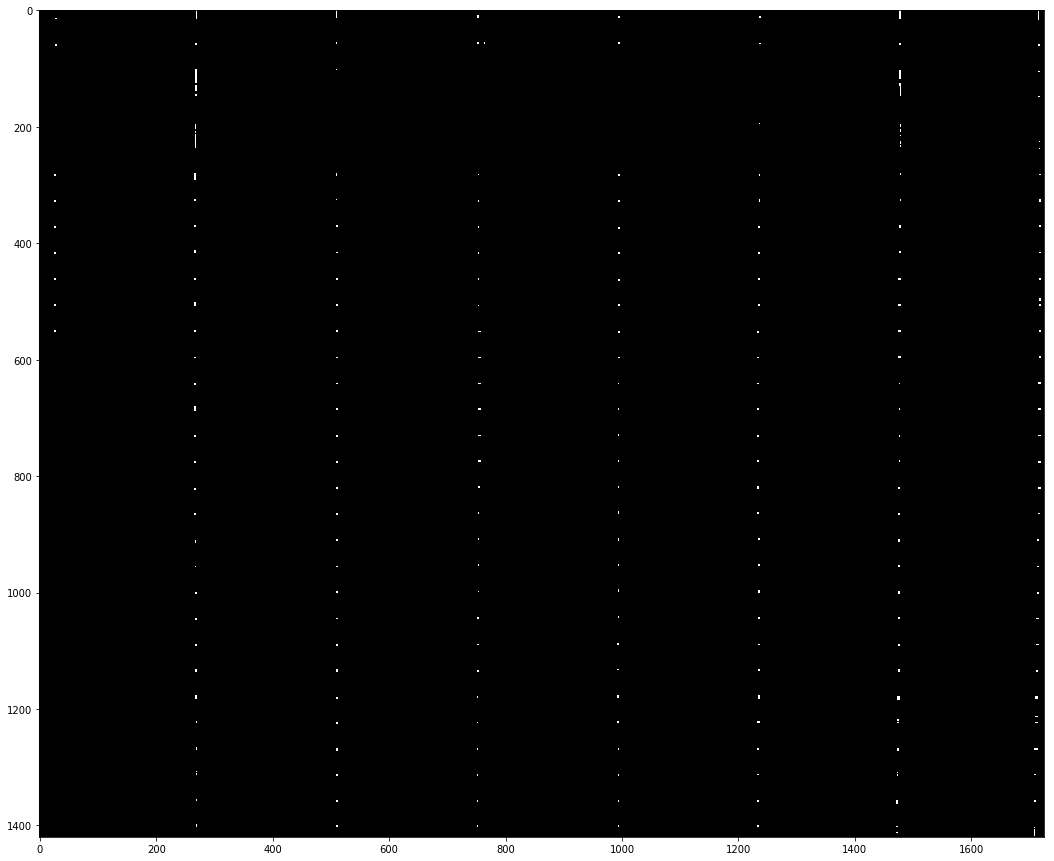

In [47]:
printImg(dotImg, 'gray')

我尝试了多种方法来复原没有检测出来的点，但是效果都不理想，考虑到表格中cell是固定大小的，针对这张图，左上角的cell是完好的，因此将其作为一个标准，求出宽高，还原原来的点图

In [13]:
# 找左上角第一个白色像素
def findLeftWhitePix(img):
    # 取图片前100列，找第一个白色像素坐标
    for i in range(img.shape[0]):
        for j in range(100):
            if img[i,j] == 255:
                return (i, j)

    return (-1, -1)

# 找当前像素右边第一个白色像素
def findRightWhitePix(img):
    # 取图片前100列，找第一个白色像素坐标
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j] == 255:
                return (i, j)

    return (-1, -1)

def drawDotPic(shape, pos, width, height):
    img = np.zeros(shape)
    for i in range(pos[0], img.shape[0], height):
        for j in range(pos[1], img.shape[1], width):
            img[i,j] = 255

    return img

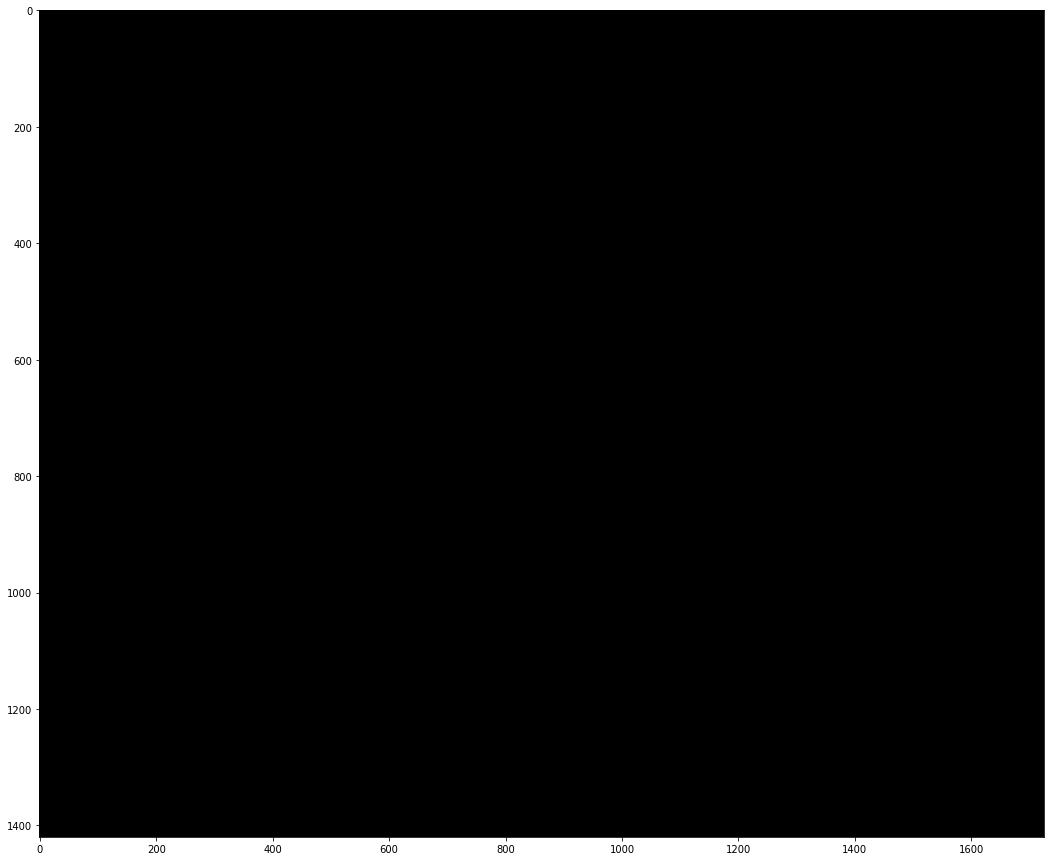

In [14]:
pos = findLeftWhitePix(dotImg)
#第一个点下面竖直的图
img2 = dotImg[pos[0]+10:,:]
pos2 = findLeftWhitePix(img2)
height = pos2[0]+10
#第一个点右边横着的图
img3 = dotImg[pos[0]:, pos[1]+100:]
pos3 = findRightWhitePix(img3)
width = pos3[1]+100

fullDotImg = drawDotPic(dotImg.shape, pos, width, height)
fullDotImg = fullDotImg.astype(np.uint8)

printImg(fullDotImg, 'gray')

由于我重新绘制的点图每个点只有1个像素，因此在这里展示出来不明显，看上去是一片黑

利用这些点来分割原图片，存到list中

In [15]:
def writeSplitImg(img, shape, pos, width, height):
    rowList = []
    for i in range(pos[0], img.shape[0], height):
        cellList = []
        for j in range(pos[1], img.shape[1], width):
            if i+height > img.shape[0] or j + width > img.shape[1]:
                break;
            cell = img[i:i+height, j+20:j+width-20]
            # cv.imwrite(path + 'cell/' + str(i) + '_' + str(j) + '.jpg', cell)
            cellList.append(cell)
        if len(cellList) != 0:
            rowList.append(cellList)

    return rowList

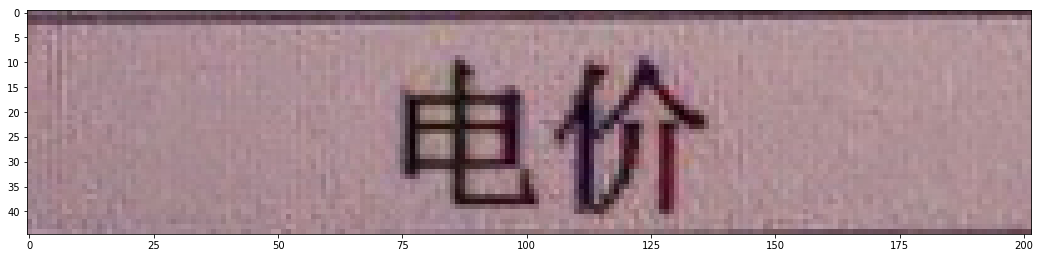

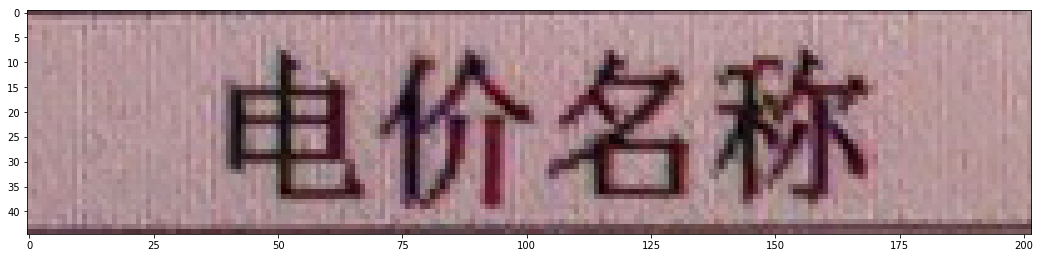

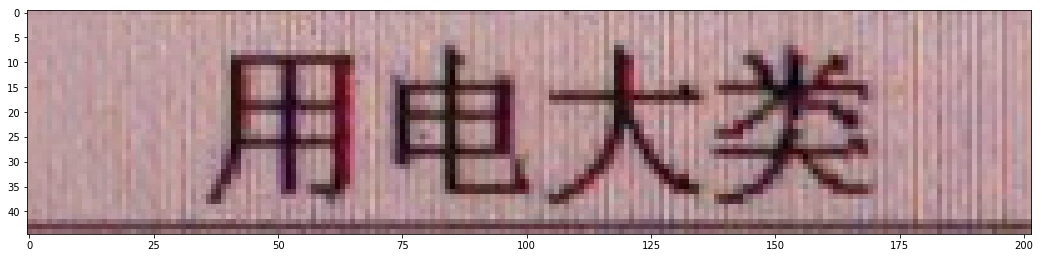

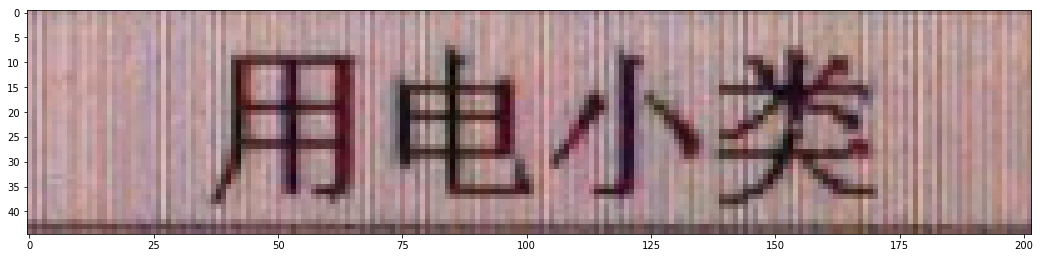

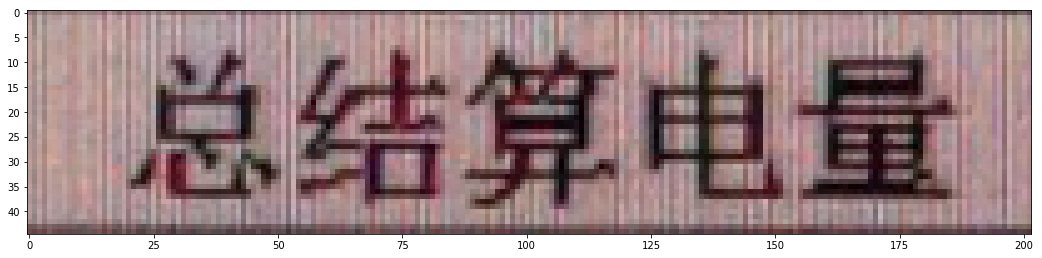

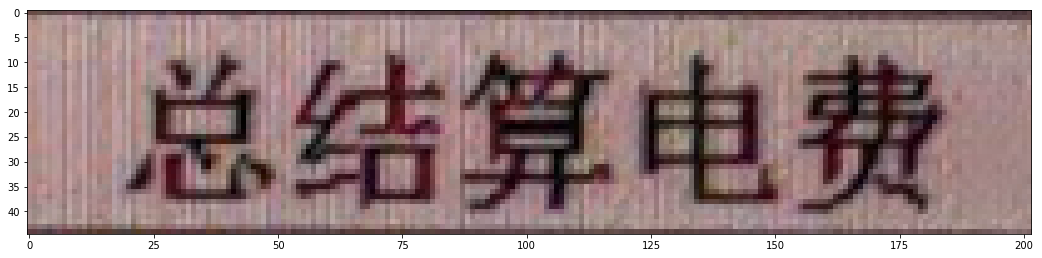

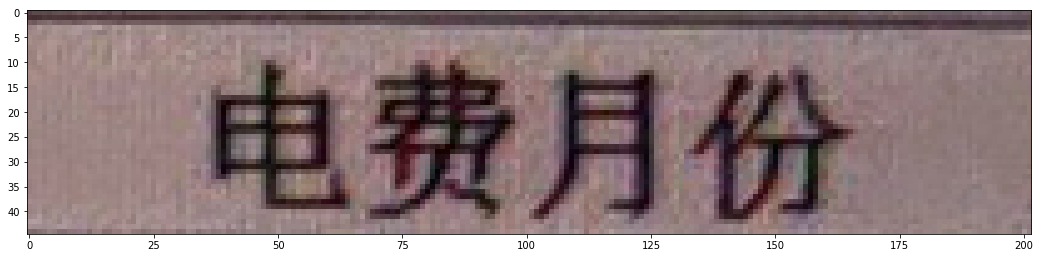

In [16]:
rowList = writeSplitImg(sourceTable, fullDotImg.shape, pos, width, height)
cellList = rowList[0]
for i in range(len(cellList)):
    printImg(cellList[i])


### 文字的识别

这里我使用Tesseract进行文字的识别

In [17]:
import pytesseract

检测出来的cell在上面的代码中已经按行顺序放入了一个cellList，然后将每一行都放入一个rowList中，这里遍历这个list，进行识别

In [18]:
def recogCell(rowList):
    count = 0
    for i in range(len(rowList)):
        cellList = rowList[i]

        for j in range(len(cellList)):
            count = count + 1
            text = pytesseract.image_to_string(cellList[j], lang='chi_sim')
            if text == '':
                print("unrecognized ", end="")
            else:
                print(text+" ", end="")
        print("")
            
    return count

In [65]:
rowList2 = writeSplitImg(sourceTable, fullDotImg.shape, pos, width, height)
count = recogCell(rowList2)


电价， ”电价名称 unrecognized 用电小类 总结算电量 总结算电费 unrecognized 
0. 5701 (大王业 大工业用电 unrecognized 45158 47061. 91 201701 
unrecognized 一般工商业 般工商业 非居民照明 9912 人有1 2 
0. 5593 KR 大工业用电 unrecognized 134956 | ,39191. 9 201702 
0 一般工商业 一般工商业 非导民照明 7674 unrecognized 2044的人 
0. 5593 大工业 大工业用电 大工业用电 34315 39418. 19 201703 
0 一般工商业 开般工商业 非居民照明 10539 | 6590. 05 unrecognized 
0 5593 大再业 大工业用电 太工业用电 39596 43147.56 201704 
ms26 一般开商业 unrecognized 非居民有照明 8692 2 0 201704 
0. 5593 了开业 大工业用电 大工业用电 | 38736. 37 201705 
0.7826 识工商业 症般开商业 非居民照明 6967 ， 6220 8 unrecognized 
0. 5593 大工业 大工业用电 unrecognized 38851 1 43116 5 201706 
0.7826 人 此吕疝业 非拷攻照明 8529 unrecognized 201706 
0. 5593 下工间 典亚业用电 让轴业用申 77255 68384. 29 201707 
0. 7826 一般工商业 条般册商业 unrecognized 16959 15148.24 201707 
0. 5502 大工业 本正业用电 太工业用电 91418 76499. 03 201708 
0. 7504 一般工商业 向肯加商业 非导民照明 20068 17302J 的 201708 
0. 5502 大工业 大工业用电 工业用电

本 69521 62656 201709 
0. 7504 一般工商业 而般山商业 非导民照明 15260 下 201709 
0. 5502 国王业 大工业用电 大工业用电 unrecognized 288 201709 
unrecognized 本般下出

直接使用原图，识别效果并不好，尝试使用中值滤波，并自适应二值化后的结果

In [66]:
rowList2 = writeSplitImg(thresMedianImg, fullDotImg.shape, pos, width, height)
count = recogCell(rowList2)

unrecognized ”中价名称 , ,用电大类半 unrecognized | 总结算电量 unrecognized se 电费月份.wm 
unrecognized unrecognized unrecognized unrecognized unrecognized unrecognized unrecognized 
unrecognized unrecognized unrecognized unrecognized unrecognized unrecognized unrecognized 
unrecognized 大工业  -和 大工业用电 | 凑工业用电 最434956-尖| unrecognized :201702 
7826泛 unrecognized 报了商业| unrecognized unrecognized unrecognized unrecognized 
0. 5593 “ -” 大工业 ;| 大工业用电， - 凑工业用电 unrecognized 39418. 19: 201703 
从 7826 一般工商站 unrecognized unrecognized 人533 unrecognized unrecognized 
0. 5593 大工业 :: 大工业用电. unrecognized unrecognized ”43147. 56 : 201704 
aa 人 了826 .二 2一般工商业， unrecognized unrecognized unrecognized unrecognized unrecognized 
”0.5593 -大工业 具工业用电: 头工业用电 unrecognized 38736. 37 ” 201705 
unrecognized unrecognized unrecognized unrecognized unrecognized unrecognized unrecognized 
和0. 5593 -大工业 : unrecognized unrecognized 38851 | -43116. 52 . 201706 - 
unrecognized unrecognized unrecognized unrecognized unrecognized unrecognized 

上面的效果也不是很好，尝试用OTSU二值化

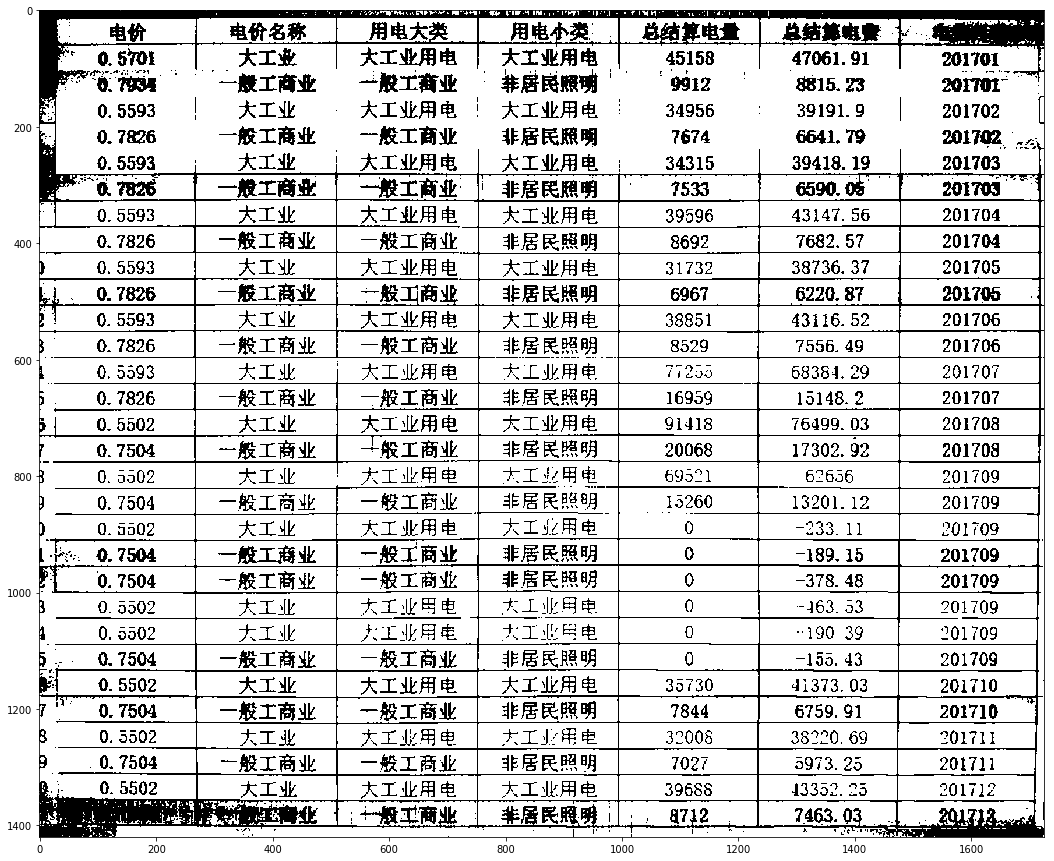

In [19]:
ret, thresOtsuImg = cv.threshold(imgMedian, 0, 255, cv.THRESH_OTSU)
printImg(thresOtsuImg, 'gray')

In [68]:
rowList2 = writeSplitImg(thresOtsuImg, fullDotImg.shape, pos, width, height)
count = recogCell(rowList2)
print("num="+str(count))

电价 电价名称 unrecognized unrecognized unrecognized unrecognized unrecognized 
.5701 大工业 大工业用电 unrecognized 45158 47061. 91 201707 
unrecognized -一般工商业 一般工次业 非居民赂硼 9912 拭15. 23 201701- 
0. 5593 大工业 大工业用电 大工业用电 34956 39191. 9 201702 
0. 7826 一般工商业 一般工商业 非居民照明 7674 6641. 79 201702  .. 
0. 5593 大工业 大工业用电 大工业用电 34315 39418. 19 201703 
unrecognized 一般工商业 unrecognized unrecognized Y533 unrecognized ”201703 
”0.5593 大工业 大工业用电 大工业用电 39596 43147. 56 201704 
0.7826 一般工商业 unrecognized 非居民照明 8692 7682. 57 201704 
0. 5593 大工业 大工业用电 大工业用电 31732 38736. 37 201705 
0. 7826 一般工商业 unrecognized 非居民照明 6967 6220. 87 201705 
0. 5593 大工业 大工业用电 unrecognized 38851 ”43116. 52 201706 
0. 7826 一般工商业 一般工商业 _非居民照明 8529 7了7556. 49 201706 
0. 5593 大工业 大工业用电 大工业用电 unrecognized 68384. 29 201707 
0. 7826 一般工商业 一般工商业 非居民照明 169359 15148. 2 201707 
0. 5502 大工业 大工业用电 大工业用电 91418 76499. 03 201708 
0. 7504 一般工商业 般工商

业 非居民照明 20068 17302. 92 201708 
0. 05502 大工业 大工业甲电 大工此用电_ 69521 6?656 201709 
0. 7504 一般工商业 一般工商业 unrecognized 15260

效果比上面两种要好一些，但是OTSU后部分数据被损坏，比如上图中最后一行的数据，而且中文的识别率还是有一定的问题

尝试使用百度API进行识别，直接对原图进行识别 

In [21]:
from aip import AipOcr
APP_ID = '15582892'
API_KEY = 'Xt6Sq24STPHp4zduLPHLSoKz'
SECRET_KEY = 'eYatFz0cUjc6BL8zGEEUe8EQI81Q5hQi'

client = AipOcr(APP_ID, API_KEY, SECRET_KEY)

def get_file_content(filePath):
    with open(filePath, 'rb') as fp:
        return fp.read()

In [72]:


originTable = get_file_content(path+name)
res = client.basicGeneral(originTable)
for item in res.get('words_result'):
    print(item['words'])

电价
电价名称用电大类用电小类总结算电量总结算电费电费月份
0.5701
大工业
大工业用电大工业用电45158
47061.91
201701
0.7934
一般工商业一般工商业非居民照明
9912
8815.23
201701
0.5593
大工业大工业用电大工业用电34963999
201702
0.7826般工商业一般工商业非居民照明
7674
6641.79
201702
0.5593
大工业大工业用电大工业用电
34315
39418.19
201703
0.7826
般工商业一般工商业非居民照明
7533
6590.05
201703
0.5593
大工业大工业用电大工业用电
39596
43147.56
201704
0.7826
般工商业一般工商业非居民照明8692
7682.57
201704
0.5593
大工业
大工业用电大工业用电
31732
38736.37
201705
0.7826
般工商业一般工商业非居民照明
6967
6220.87
201705
0.5593
大工业
大工业用电大工业用电
38851
4311652
201706
0.7826
般工商业一般工商业非居民照明
8529
7556.49
201706
0.5593
大工业
大工业用电大工业用电775
68384.29
201707
0.7826
般工商业一般工商业非居民照明
16959
15148.2
201707
0.5502
大工业
大工业用电大工业用电
91418
76499.03
201708
0.7504
般工商业一般工商业非居民照明
20068
17302.92
201708
0.5502
大工业大工业用电大工业用电
69521
62656
201709
0.7504
般工商业一般工商业非居民照明
15260
13201.12
201709
0.5502
大工业
大工业用电大工业用电
0
233.11
201709
0.7504
般工商业一般工商业非居民照明
189.15
201709
0.7504
般工商业一般工商业非居民照明
378.48
201709
0.5502
大工业大工业用电大工业用电
0.5502
大工业
大工业用电大工业用电
0000
463.53
201709
190.39
201709
0.7504
般工商业一般工商业非居民照明
155

可以看到，用百度OCR的API，基本能识别出来，但是有小部分错误，比如“一般工商业”的“一”，经常没有识别出来

由于百度的api只支持base64编码的数据的传输，在opencv的mat数据转base64的情况下，出现了一些难以处理的bug，因此这里我先把cell存为jpg图片文件，然后通过打开文件流的方式，直接得到base64的数据。

In [76]:
import os
cellPath = path+'thresCell/'

fileList = os.listdir(cellPath)
for fileName in fileList:
    img = get_file_content(cellPath + fileName)
    res = client.basicGeneral(img)
    for item in res.get('words_result'):
        print(item['words'])

电价
大工业用电
般工商业
般工商业
非居民照明
16959
15148.2
201707
0.5502
大工业
大工业用电
大工业用电
大工业用电
91418
76499.03
201708
0.7504
般工商业
般工商业
非居民照明
20068
17302.92
201708
45158
0.5502
大工业
大工业用电
大工业用电
69521
62656
201709
0.7504
般工商业
般工商业
47061.91
非居民照明
15260
13201.12
201709
0.5502
大工业
大工业用电
大工业用电
0
233.11
201701
201709
0.7504
般工商业
般工商业
非居民照明
0
-189.15
201709
0.7504
般工商业
0.7934
一般工商业
非居民照明
0
-378.48
201709
0.5502
大工业
大工业用电
大工业用电
0
般工商业
-463.53
201709
0.5502
大工业
大工业用电
大工业用电
0
190.39
201709
0.7504
般工商业
般工商业
般工商业
非居民照明
0
-155.43
201709
0.5502
大工业
大工业用电
大工业用电
非居民照明
35730
41373.03
201710
0.7504
般工商业
般工商业
非居民照明
7844
6759.91
201710
9912
0.5502
大工业
大工业用电
大工业用电
32008
38220.69
201711
0.7504
般工商业
般工商业
电价名称
8815.23
非居民照明
7027
5973.25
201711
0.5502
大工业
大工业用电
大工业用电
39688
43352.25
201701
201712
0.7504
般工商业
般工商业
非居民照明
8712
7463.03
201712
0.5593
大工业
大工业用电
大工业用电
34956
39191.9
201702
0.7826
用电大类
般工商业
般工商业
非居民照明
7674
6641.79
201702
0.5593
大工业
大工业用电
大工业用电
用电小类
34315
39418.19
201703
0.7826
般工商业
般工商业
非居民照明
7533
6590.05
201703
总结算电量
0.5593


上面的数据是，只做了转为灰度图片，并且中值滤波之后的图片的结果，正确率和整张图放进去识别比起来没有太大的差距

In [77]:
cellPath2 = path+'thresCell2/'

fileList = os.listdir(cellPath2)
for fileName in fileList:
    img = get_file_content(cellPath2 + fileName)
    res = client.basicGeneral(img)
    for item in res.get('words_result'):
        print(item['words'])

电价
“大工业用电
般工商
般工商业
非居民照明训
16959
148
7分多
:0.5502
大工业
1大工业用电
太工业用电
试大工业用电
91418
76499.03
:201708
n7504
酬般工商业
斜是般工商业
群非居民照明
W址2068
种322
917Q3
E:145158
0.5502
大工业
大工业用电
1大工业用电
69521
626
201709
a.7504
般工商
操般工商业时
47061.9
单菲居民照明
5260H
43201:1
2017
0.5502
大工业
大工业用电
大工业用电
10
233.11
氵.2017014
201709
秘750A
烈般工商业
般工商业
H非居民照明
幼联!
20170g示
3.7504
般工商业
第3
般工商业k
非居民照勇
P
38
201709
0.5502
大工业
r
大工业用电
大工业用电
越
0
最工商业
:-46353
201709
0.5502
大工业
大工业用电
大工业用电
:{5
190.39
20170
2Q7504
般工商业
般工商
订般工商业
鞋居民照明
Firi E i
H种5432
0.5502
大工业
大工业用电
大工业用电
滕非屠民腰项圳
35730
41373.03
201710
c7504
般工商业解
般工商
E民照明
种8441
6759
202710%
0.5502
大工业
大工业用电
大工业用电
:32008
38220.69
201711
~750
化效丁商业
般工商
电价名称xs
菲居民照明
单限702n
507325
2017
0.5502
大工业
大工业用电
大工业用电
:39688
43352.25
20170
201712
光25
工商业
工商
居民照明
出名72+N
3463.05
20172
☆0.5593
偏大工业
大工业用电
大工业用电
别￥N349564
:39191.9笋
:2017029
78
,用电大类
般工商
绿般工商业
居民照曠
H64减
377
0.5593
大工业
大工业用电
艾工业用电
i用电小类谢
:#:34315的
39418.19
201703
7826
之般工商业
(投工商业
非居民照明
|533
6590款
20170
总结算电量
0.5593
大工业:
大工业用电
l大工业用电
39596
43147.

上面是自适应二值化之后的结果，使用百度的api，正确率不如只中值滤波的

对于用OTSU二值化的结果，也进行识别

In [78]:
otsuPath = path+'thresCell3/'

fileList = os.listdir(otsuPath)
for fileName in fileList:
    img = get_file_content(otsuPath + fileName)
    res = client.basicGeneral(img)
    for item in res.get('words_result'):
        print(item['words'])

电价
大工业用电
般工商业
般工商业
非居民照明
16959
15148.2
201707
0.5502
大工业
大工业用电
大工业用电
大工业用电
91418
76499.03
201708
0.7504
般工商业
般工商业
非居民照明
20068
17302.92
201708
45158
0.5302
大工业
大工业用电
大工总用电
69321
62656
201709
0.7504
般工商业
般工商业
47061.91
非居民照明
15260
13201.12
201709
0.5502
大工业
大工业用电
大工业用电
233.11
201701
201709
0.7504
般工商业
般工商业
非居民照明
0
189.15
201709
0.7504
般工商业
般工商业
非居民照明
0
378.48
201709
0.5502
大工业
大工业明电
大工业电
0
般工商业
-163.53
201709
0.5502
大工业
大工业用电
大工业国电
0
190.39
201709
0.7504
一般工商业
般工商业
般工商业
非居民照明
0
155.43
201709
0.5502
大工业
大工业用电
大工业用电
非居民明
35730
4i373.03
201710
0.7504
般工商业
般工商业
非居民照明
7844
6759,91
201710
9912
0.5502
大工业
大工业用电
大工业用电
32008
38220.69
201711
0.7504
般工商业
般工商业
电价名称
15z3
非居民照明
7027
5973.25
20711
0.5502
大工业
大工业用电
大工业用电
39688
13352.25
201712
小
1:A,x32
做般工商业
非屠民照明
8712
7463.03
0.5593
大工业
大工业用电
大工业用电
34956
39191.9
201702
0。7826
用电大类
般工商业
般工商业
非居民照明
7674
1.79
20170,
0.5593
大工业
大工业用电
大工业用电
用电小类
34315
39418.19
201703
般工商业
般工商业
非居民照明
7533
590,95
2017u5
总结算啦
0.5593
大工业
大工业用电
大工业用电
39596
43147.56
201704
0.7826


粗略观察下来，大部分数据还是识别出来了，但是由于OTSU二值化后，部分数据（比如最后一行第一第二列）已经损失，所以识别率相较于没有处理的整张图，并没有提升，甚至有下降。

对比原图和直接识别cell图片的结果，发现错误的都是“一般工商业”，缺少“一”，因此这里检测单词前缀，是“般”的情况下，就加上“一”

In [38]:
import os

cellPath = path+'thresCell/'
def printRecogItem(path):
    fileList = os.listdir(path)
    for i in range(1,len(fileList)+1):
        img = get_file_content(path + str(i)+'.jpg')
        res = client.basicGeneral(img)
        for item in res.get('words_result'):
            word = item['words']
            if word.startswith("般"):
                word = "一"+ word
            print(word)

In [37]:
printRecogItem(cellPath)

电价
电价名称
用电大类
用电小类
总结算电量
总结算电费
电费月份
0.5701
大工业
大工业用电
大工业用电
45158
47061.91
201701
0.7934
一般工商业
一般工商业
非居民照明
9912
8815.23
201701
0.5593
大工业
大工业用电
大工业用电
34956
39191.9
201702
0.7826
一般工商业
一般工商业
非居民照明
7674
6641.79
201702
0.5593
大工业
大工业用电
大工业用电
34315
39418.19
201703
0.7826
一般工商业
一般工商业
非居民照明
7533
6590.05
201703
0.5593
大工业
大工业用电
大工业用电
39596
43147.56
201704
0.7826
一般工商业
一般工商业
非居民照明
8692
7682.57
201704
0.5593
大工业
大工业用电
大工业用电
31732
38736.37
201705
0.7826
一般工商业
一般工商业
非居民照明
6967
6220.87
201705
0.5593
大工业
大工业用电
大工业用电
38851
43116.52
201706
0.7826
一般工商业
一般工商业
非居民照明
8529
7556.49
201706
0.5593
大工业
大工业用电
大工业用电
77255
68384.29
201707
0.7826
一般工商业
一般工商业
非居民照明
16959
15148.2
201707
0.5502
大工业
大工业用电
大工业用电
91418
76499.03
201708
0.7504
一般工商业
一般工商业
非居民照明
20068
17302.92
201708
0.5502
大工业
大工业用电
大工业用电
69521
62656
201709
0.7504
一般工商业
一般工商业
非居民照明
15260
13201.12
201709
0.5502
大工业
大工业用电
大工业用电
0
233.11
201709
0.7504
一般工商业
一般工商业
非居民照明
0
-189.15
201709
0.7504
一般工商业
一般工商业
非居民照明
0
-378.48
201709
0.5502
大工业
大工业用电
大工业用电
0
-463.5